In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.stem import WordNetLemmatizer
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
n = 1000

# Any results you write to the current directory are saved as output.

In [129]:
#df = pd.read_csv('metadata.csv')
bucket = 'coviddata'
file = 'metadata.csv'
gcs_url = 'https://%(bucket)s.storage.googleapis.com/%(file)s' % {'bucket':bucket, 'file':file}
df = pd.read_csv(gcs_url)

In [10]:
df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [11]:
df.shape

(44220, 15)

In [99]:
df.iloc[[10]]

,title,doi,pubmed_id,abstract,publish_time,authors,journal,full_text_file,document
13,Monoclonal antibodies identify multiple epitop...,10.1016/0006-291X(85)91946-1,2409966.0,Abstract Nine hybridoma cell lines secreting a...,1985-06-28,"Cherel, Isabelle; Grosclaude, Jeanne; Rouze, P...",Biochemical and Biophysical Research Communica...,custom_license,Monoclonal antibodies identify multiple epitop...


In [12]:
 # Some papers are duplicated since they were collected from separate sources. Thanks Joerg Rings
duplicate_paper = ~(df.title.isnull() | df.abstract.isnull()) & (df.duplicated(subset=['title', 'abstract']))
df = df[~duplicate_paper].reset_index(drop=True)

df = df.dropna(subset=['abstract'])

# create a column that appends title+abstract. This column will be the "document" that all searching/clustering/vectorization will use
df['document'] = df['title'] + '. ' + df['abstract']
print(df.shape)

(35443, 16)


In [13]:
df.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,document
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license,Intrauterine virus infections and congenital h...
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license,Clinical and immunologic studies in identical ...


In [136]:
df = df.drop(columns = ['sha', 'source_x', 'pmcid', 'license', 'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text'])

In [18]:
df.head()

,title,doi,pubmed_id,abstract,publish_time,authors,journal,full_text_file,document
0,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,4361535.0,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,custom_license,Intrauterine virus infections and congenital h...
3,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,4579077.0,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,custom_license,Clinical and immunologic studies in identical ...
4,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,4014285.0,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,custom_license,Epidemiology of community-acquired respiratory...
5,Infectious diarrhea: Pathogenesis and risk fac...,10.1016/0002-9343(85)90367-5,2861742.0,Abstract Our understanding of the pathogenesis...,1985-06-28,"Cantey, J.Robert",The American Journal of Medicine,custom_license,Infectious diarrhea: Pathogenesis and risk fac...
6,New perspectives on the pathogenesis of rheuma...,10.1016/0002-9343(88)90356-7,3052052.0,Abstract In the pathogenesis of rheumatoid art...,1988-10-14,"Zvaifler, Nathan J.",The American Journal of Medicine,custom_license,New perspectives on the pathogenesis of rheuma...


In [55]:
df.shape

(35443, 9)

In [22]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'see', 'figure', 'for', 'data','not', 'cleared','new', 'sentence', 'here','finally','also', 'could', 'thus', 'therefore','virus','infection','cell', 'protein','use','study','viral','disease','result','human'])

In [23]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [32]:
# Convert to list
data = df.document.values.tolist()
data


['Intrauterine virus infections and congenital heart disease. Abstract The etiologic basis for the vast majority of cases of congenital heart disease remains largely undefined. Viruses have been considered to be likely candidates since the recognition of the association between intrauterine rubella and congenital heart disease. Although the pathogenesis of cardiovascular defects is poorly understood, information gained from the study of congenital rubella syndrome suggests that mechanisms such as focal endothelial cell damage, resulting in obliteration of vascular supply, decreased growth rate, and shortened survival time of certain cells, and disturbed DNA replication in cells whose chromosomes were damaged secondary to the effects of virus replication may be operative in the production of defects in the developing fetus. In addition to rubella there is suggestive, but not conclusive, evidence that Coxsackie B3 and B4 virus infections during pregnancy can result in the birth of infant

# Avoid least frequent and rare words

In [28]:
clean_words = df['document'].tolist()
clean_words[1]

'Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus. Abstract Middle-aged female identical twins, one of whom had systemic lupus erythematosus (SLE), were evaluated for immunologic reactivity to previous antigenic challenges, including primary immunization with a foreign antigen, keyhole limpet hemocyanin (KLH). These two women had lived together for all of their 58 years and neither was receiving anti-inflammatory or immunosuppressive drugs at the time of these studies. Both twins demonstrated comparable 7S and 198 humoral antibody response to KLH, as well as similar viral antibody titers. However, the twin with SLE was anergic to common antigens, streptokinase-streptodornase, Trichophyton and Candida; furthermore delayed hypersensitivity to KLH did not develop after immunization. This observed discrepancy between humoral and cellular immunity in genetically similar subjects may be significant in the pathogenesis of SLE.'

In [33]:
import re


data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

TypeError: expected string or bytes-like object

In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['intrauterine', 'virus', 'infections', 'and', 'congenital', 'heart', 'disease', 'abstract', 'the', 'etiologic', 'basis', 'for', 'the', 'vast', 'majority', 'of', 'cases', 'of', 'congenital', 'heart', 'disease', 'remains', 'largely', 'undefined', 'viruses', 'have', 'been', 'considered', 'to', 'be', 'likely', 'candidates', 'since', 'the', 'recognition', 'of', 'the', 'association', 'between', 'intrauterine', 'rubella', 'and', 'congenital', 'heart', 'disease', 'although', 'the', 'pathogenesis', 'of', 'cardiovascular', 'defects', 'is', 'poorly', 'understood', 'information', 'gained', 'from', 'the', 'study', 'of', 'congenital', 'rubella', 'syndrome', 'suggests', 'that', 'mechanisms', 'such', 'as', 'focal', 'endothelial', 'cell', 'damage', 'resulting', 'in', 'obliteration', 'of', 'vascular', 'supply', 'decreased', 'growth', 'rate', 'and', 'shortened', 'survival', 'time', 'of', 'certain', 'cells', 'and', 'disturbed', 'dna', 'replication', 'in', 'cells', 'whose', 'chromosomes', 'were', 'damage

In [38]:
from collections import Counter
from itertools import chain
import operator


print(str(len(data_words)) + ' total words in corpus')

counter_obj = Counter(chain.from_iterable(data_words))
word_counts = counter_obj.most_common()
word_counts.sort(key=operator.itemgetter(1), reverse=True)

word_counts[0:10]

35443 total words in corpus


[('the', 374891),
 ('of', 327993),
 ('and', 273058),
 ('in', 202820),
 ('to', 147136),
 ('for', 77202),
 ('with', 77038),
 ('that', 62064),
 ('is', 54007),
 ('were', 49302)]

# Creating Bigram and Trigram Models

In [39]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['intrauterine', 'virus', 'infections', 'and', 'congenital_heart', 'disease', 'abstract', 'the', 'etiologic', 'basis', 'for', 'the', 'vast_majority', 'of', 'cases', 'of', 'congenital_heart', 'disease', 'remains', 'largely_undefined', 'viruses', 'have', 'been', 'considered', 'to', 'be', 'likely', 'candidates', 'since', 'the', 'recognition', 'of', 'the', 'association', 'between', 'intrauterine', 'rubella', 'and', 'congenital_heart', 'disease', 'although', 'the', 'pathogenesis', 'of', 'cardiovascular', 'defects', 'is', 'poorly_understood', 'information', 'gained', 'from', 'the', 'study', 'of', 'congenital', 'rubella', 'syndrome', 'suggests', 'that', 'mechanisms', 'such', 'as', 'focal', 'endothelial', 'cell', 'damage', 'resulting', 'in', 'obliteration', 'of', 'vascular', 'supply', 'decreased', 'growth', 'rate', 'and', 'shortened', 'survival', 'time', 'of', 'certain', 'cells', 'and', 'disturbed', 'dna', 'replication', 'in', 'cells', 'whose', 'chromosomes', 'were', 'damaged', 'secondary', 't

# Remove Stopwords, Make Bigrams and Lemmatize

In [40]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [41]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['intrauterine', 'infection', 'abstract', 'etiologic', 'basis', 'vast_majority', 'case', 'remain', 'largely_undefined', 'virus', 'consider', 'likely', 'candidate', 'association', 'intrauterine', 'rubella', 'pathogenesis', 'cardiovascular', 'defect', 'information', 'gain', 'congenital', 'rubella', 'syndrome', 'suggest', 'mechanism', 'focal', 'endothelial', 'damage', 'result', 'obliteration', 'vascular', 'supply', 'decrease', 'growth', 'rate', 'shorten', 'survival', 'time', 'certain', 'cell', 'disturb', 'dna', 'replication', 'cell', 'chromosome', 'damage', 'secondary', 'effect', 'replication', 'may', 'operative', 'production', 'defect', 'develop', 'fetus', 'addition', 'rubella', 'suggestive', 'conclusive', 'evidence', 'coxsackie', 'infection', 'pregnancy', 'birth', 'infant', 'variety', 'type', 'lesion', 'intrauterine', 'mump', 'may', 'etiologically', 'relate', 'postnatal', 'development', 'endocardial', 'fibroelastosis', 'efe', 'number', 'virus', 'potential', 'etiologic_agent', 'current'

# Create the Dictionary and Corpus needed for Topic Modeling

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 3), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 2), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1)]]


In [43]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abnormal', 1),
  ('abstract', 1),
  ('addition', 1),
  ('agent', 1),
  ('allow', 1),
  ('animal', 1),
  ('appear', 1),
  ('area', 1),
  ('association', 2),
  ('basis', 1),
  ('birth', 1),
  ('candidate', 1),
  ('cardiovascular', 1),
  ('case', 1),
  ('causative', 1),
  ('cell', 2),
  ('certain', 1),
  ('chromosome', 1),
  ('conclusive', 1),
  ('congenital', 1),
  ('consider', 1),
  ('control', 1),
  ('coxsackie', 1),
  ('current', 1),
  ('damage', 2),
  ('decrease', 1),
  ('defect', 3),
  ('depend', 1),
  ('depth', 1),
  ('develop', 1),
  ('development', 2),
  ('disturb', 1),
  ('dna', 1),
  ('early', 1),
  ('efe', 1),
  ('effect', 1),
  ('effective', 1),
  ('endocardial', 1),
  ('endothelial', 1),
  ('epidemiology', 1),
  ('etiologic', 1),
  ('etiologic_agent', 1),
  ('etiologically', 1),
  ('even', 1),
  ('evidence', 1),
  ('fetus', 1),
  ('fibroelastosis', 1),
  ('focal', 1),
  ('future', 1),
  ('gain', 1),
  ('gestation', 1),
  ('growth', 1),
  ('identify', 1),
  ('inadequate',

# 1Finding optimum vlaue. 

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#  Building the Topic Model

In [44]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

In [45]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"cell" + 0.027*"activity" + 0.021*"replication" + 0.019*"antiviral" + '
  '0.018*"receptor" + 0.016*"protein" + 0.014*"spread" + 0.013*"target" + '
  '0.012*"show" + 0.012*"cellular"'),
 (1,
  '0.079*"vaccine" + 0.055*"antibody" + 0.024*"response" + 0.023*"specific" + '
  '0.019*"recombinant" + 0.017*"epitope" + 0.016*"screen" + 0.016*"vector" + '
  '0.016*"candidate" + 0.015*"development"'),
 (2,
  '0.078*"sequence" + 0.050*"genome" + 0.029*"mutation" + 0.023*"strain" + '
  '0.017*"genomic" + 0.017*"cluster" + 0.014*"analysis" + 0.013*"dna" + '
  '0.012*"encode" + 0.012*"isolate"'),
 (3,
  '0.023*"structure" + 0.022*"domain" + 0.019*"bind" + 0.018*"site" + '
  '0.017*"region" + 0.015*"protein" + 0.013*"structural" + 0.012*"reveal" + '
  '0.011*"identify" + 0.011*"suggest"'),
 (4,
  '0.044*"gene" + 0.040*"host" + 0.036*"virus" + 0.022*"identify" + '
  '0.017*"use" + 0.016*"specie" + 0.015*"study" + 0.014*"include" + '
  '0.012*"genetic" + 0.012*"different"'),
 (5,
  '0.04

# Compute Model Perplexity and Coherence Score

In [46]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.291155924537744

Coherence Score:  0.5416819148439141


# LSA and LDA

In [58]:
from gensim import models, corpora
NUM_TOPICS = 20
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)
 


 

In [50]:
from gensim import models, corpora
NUM_TOPICS = 10
# Build the LSI model
lsi_model = models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)

In [59]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))
 
print("=" * 20)
 
print("LSI Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lsi_model.print_topic(idx, 10))
 
print("=" * 20)
 

LDA Model:
Topic #0: 0.040*"cell" + 0.019*"host" + 0.017*"response" + 0.015*"expression" + 0.014*"induce" + 0.014*"immune" + 0.012*"role" + 0.010*"mechanism" + 0.010*"replication" + 0.009*"factor"
Topic #1: 0.027*"pig" + 0.025*"particle" + 0.022*"prrsv" + 0.020*"response" + 0.012*"kinase" + 0.011*"syndrome" + 0.010*"respiratory" + 0.009*"induce" + 0.009*"immune" + 0.008*"phosphorylation"
Topic #2: 0.056*"respiratory" + 0.040*"virus" + 0.036*"infection" + 0.023*"influenza" + 0.017*"detect" + 0.017*"cause" + 0.014*"sample" + 0.014*"tract" + 0.013*"pathogen" + 0.012*"clinical"
Topic #3: 0.031*"use" + 0.029*"detection" + 0.021*"method" + 0.021*"sample" + 0.021*"test" + 0.016*"assay" + 0.016*"detect" + 0.013*"sensitivity" + 0.012*"base" + 0.012*"result"
Topic #4: 0.075*"antibody" + 0.046*"bat" + 0.021*"pedv" + 0.014*"dog" + 0.013*"test" + 0.012*"animal" + 0.011*"serum" + 0.010*"use" + 0.009*"line" + 0.009*"sample"
Topic #5: 0.034*"mouse" + 0.020*"infect" + 0.019*"cell" + 0.017*"cd" + 0.013*

In [51]:


# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score LSA: ', coherence_lsi)


Coherence Score LSA:  0.4250814479126646


In [ ]:
# Compute Perplexity
print('\nPerplexity LDA: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDA: ', coherence_lda)

# Visualize the topics-keywords

In [52]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.087994  0.127301       1        1  17.672720
7     -0.087894  0.134344       2        1  14.541043
5     -0.225251 -0.183209       3        1  12.508157
0      0.041418  0.113848       4        1  11.409873
6     -0.126151 -0.058388       5        1  11.101973
4     -0.024263  0.082465       6        1   9.189076
3     -0.005269 -0.081543       7        1   8.297389
9     -0.023799 -0.115103       8        1   6.911838
1      0.213972  0.225559       9        1   4.424514
2      0.325232 -0.245273      10        1   3.943422, topic_info=     Category          Freq      Term         Total  loglift  logprob
216   Default  19411.000000   patient  19411.000000  30.0000  30.0000
100   Default  11498.000000   vaccine  11498.000000  29.0000  29.0000
515   Default  10080.000000  sequence  10080.000000  28.0000  28.0000
265   Default  13355.000000      gene  13355.000000  27.0000  27.0000
104   Default  17117.000000     virus  17117.000000  26.0000  26.0000
...       ...           ...       ...           ...      ...      ...
455   Topic10   1064.553223   contain   4316.237305   1.8333  -4.8018
850   Topic10   1041.408447    single   4429.195312   1.7855  -4.8237
1354  Topic10   1131.000977     novel   8119.099609   1.2620  -4.7412
545   Topic10   1069.977661    reveal   6492.761230   1.4301  -4.7967
1518  Topic10    965.325073    region   5773.510742   1.4446  -4.8996

[549 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4949      5  0.999395      access
5277      8  0.999546    accuracy
7929      4  0.998866         ace
289       2  0.999728    activate
585       2  0.999841  activation
...     ...       ...         ...
4148      3  0.999466       world
154       3  0.999888        year
4260     10  0.998219       yeast
241       5  0.999477       young
7240      1  0.999455    zoonotic

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 6, 1, 7, 5, 4, 10, 2, 3])

# Gensim offers a simple way of performing similarity queries using topic models.

In [60]:
from gensim import similarities
lda_index = similarities.MatrixSimilarity(lda_model[corpus])







In [74]:
from nltk import word_tokenize
STOPWORDS = stopwords.words('english')
def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return cleaned_text

In [87]:
text = 'What is known about transmission, incubation, and environmental stability'

In [88]:


bow = id2word.doc2bow(clean_text(text))
# Let's perform some queries
similarities = lda_index[lda_model[bow]]
# Sort the similarities
similarities = sorted(enumerate(similarities), key=lambda item: -item[1])

In [90]:
# Top most similar documents:
print(similarities[:10])

[(6447, 0.7974143), (10126, 0.741133), (26167, 0.7299697), (1489, 0.71916085), (21505, 0.7089921), (21811, 0.7044254), (5819, 0.69797486), (21717, 0.69584024), (34270, 0.68754905), (21050, 0.6843891)]


In [128]:
df.iloc[1]

word              virus
topic_id              2
importance    0.0399194
word_count        16208
Name: 1, dtype: object

In [137]:
document_id_list=[]
for x in range(0, 3):
    document_id, similarity = similarities[x]
    document_id_list.append(document_id)
df.iloc[document_id_list]

df.drop(columns = ['sha', 'source_x', 'pmcid', 'license', 'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text'])

,title,doi,pubmed_id,abstract,publish_time,authors,journal,full_text_file
6447,Improving estimates of the basic reproductive ...,10.1016/j.tpb.2006.03.003,16712889.0,Abstract In both within-host and epidemiologic...,2006-09-30,"Heffernan, J.M.; Wahl, L.M.",Theoretical Population Biology,custom_license
10126,Infection control in countries with limited re...,10.1016/S0195-6701(07)60033-4,17540260.0,NaN,2007-06-30,"Lynch, Patricia; Pittet, Didier; Borg, Michael...",Journal of Hospital Infection,custom_license
26167,How to Avoid a No-Deal ER Exit,10.3390/cells8091051,31500301.0,Efficiency and fidelity of protein secretion a...,2019 Sep 7,"Anelli, Tiziana; Panina-Bordignon, Paola",Cells,comm_use_subset


# Word Clouds of Top N Keywords in Each Topic

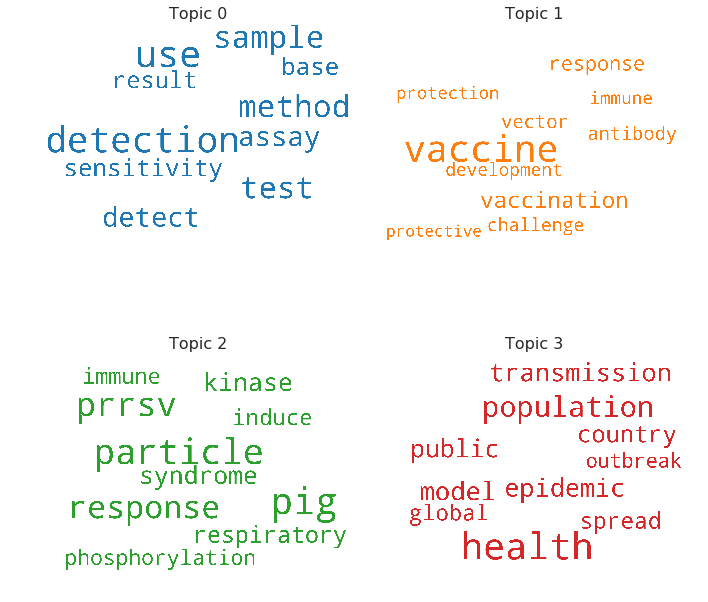

In [110]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

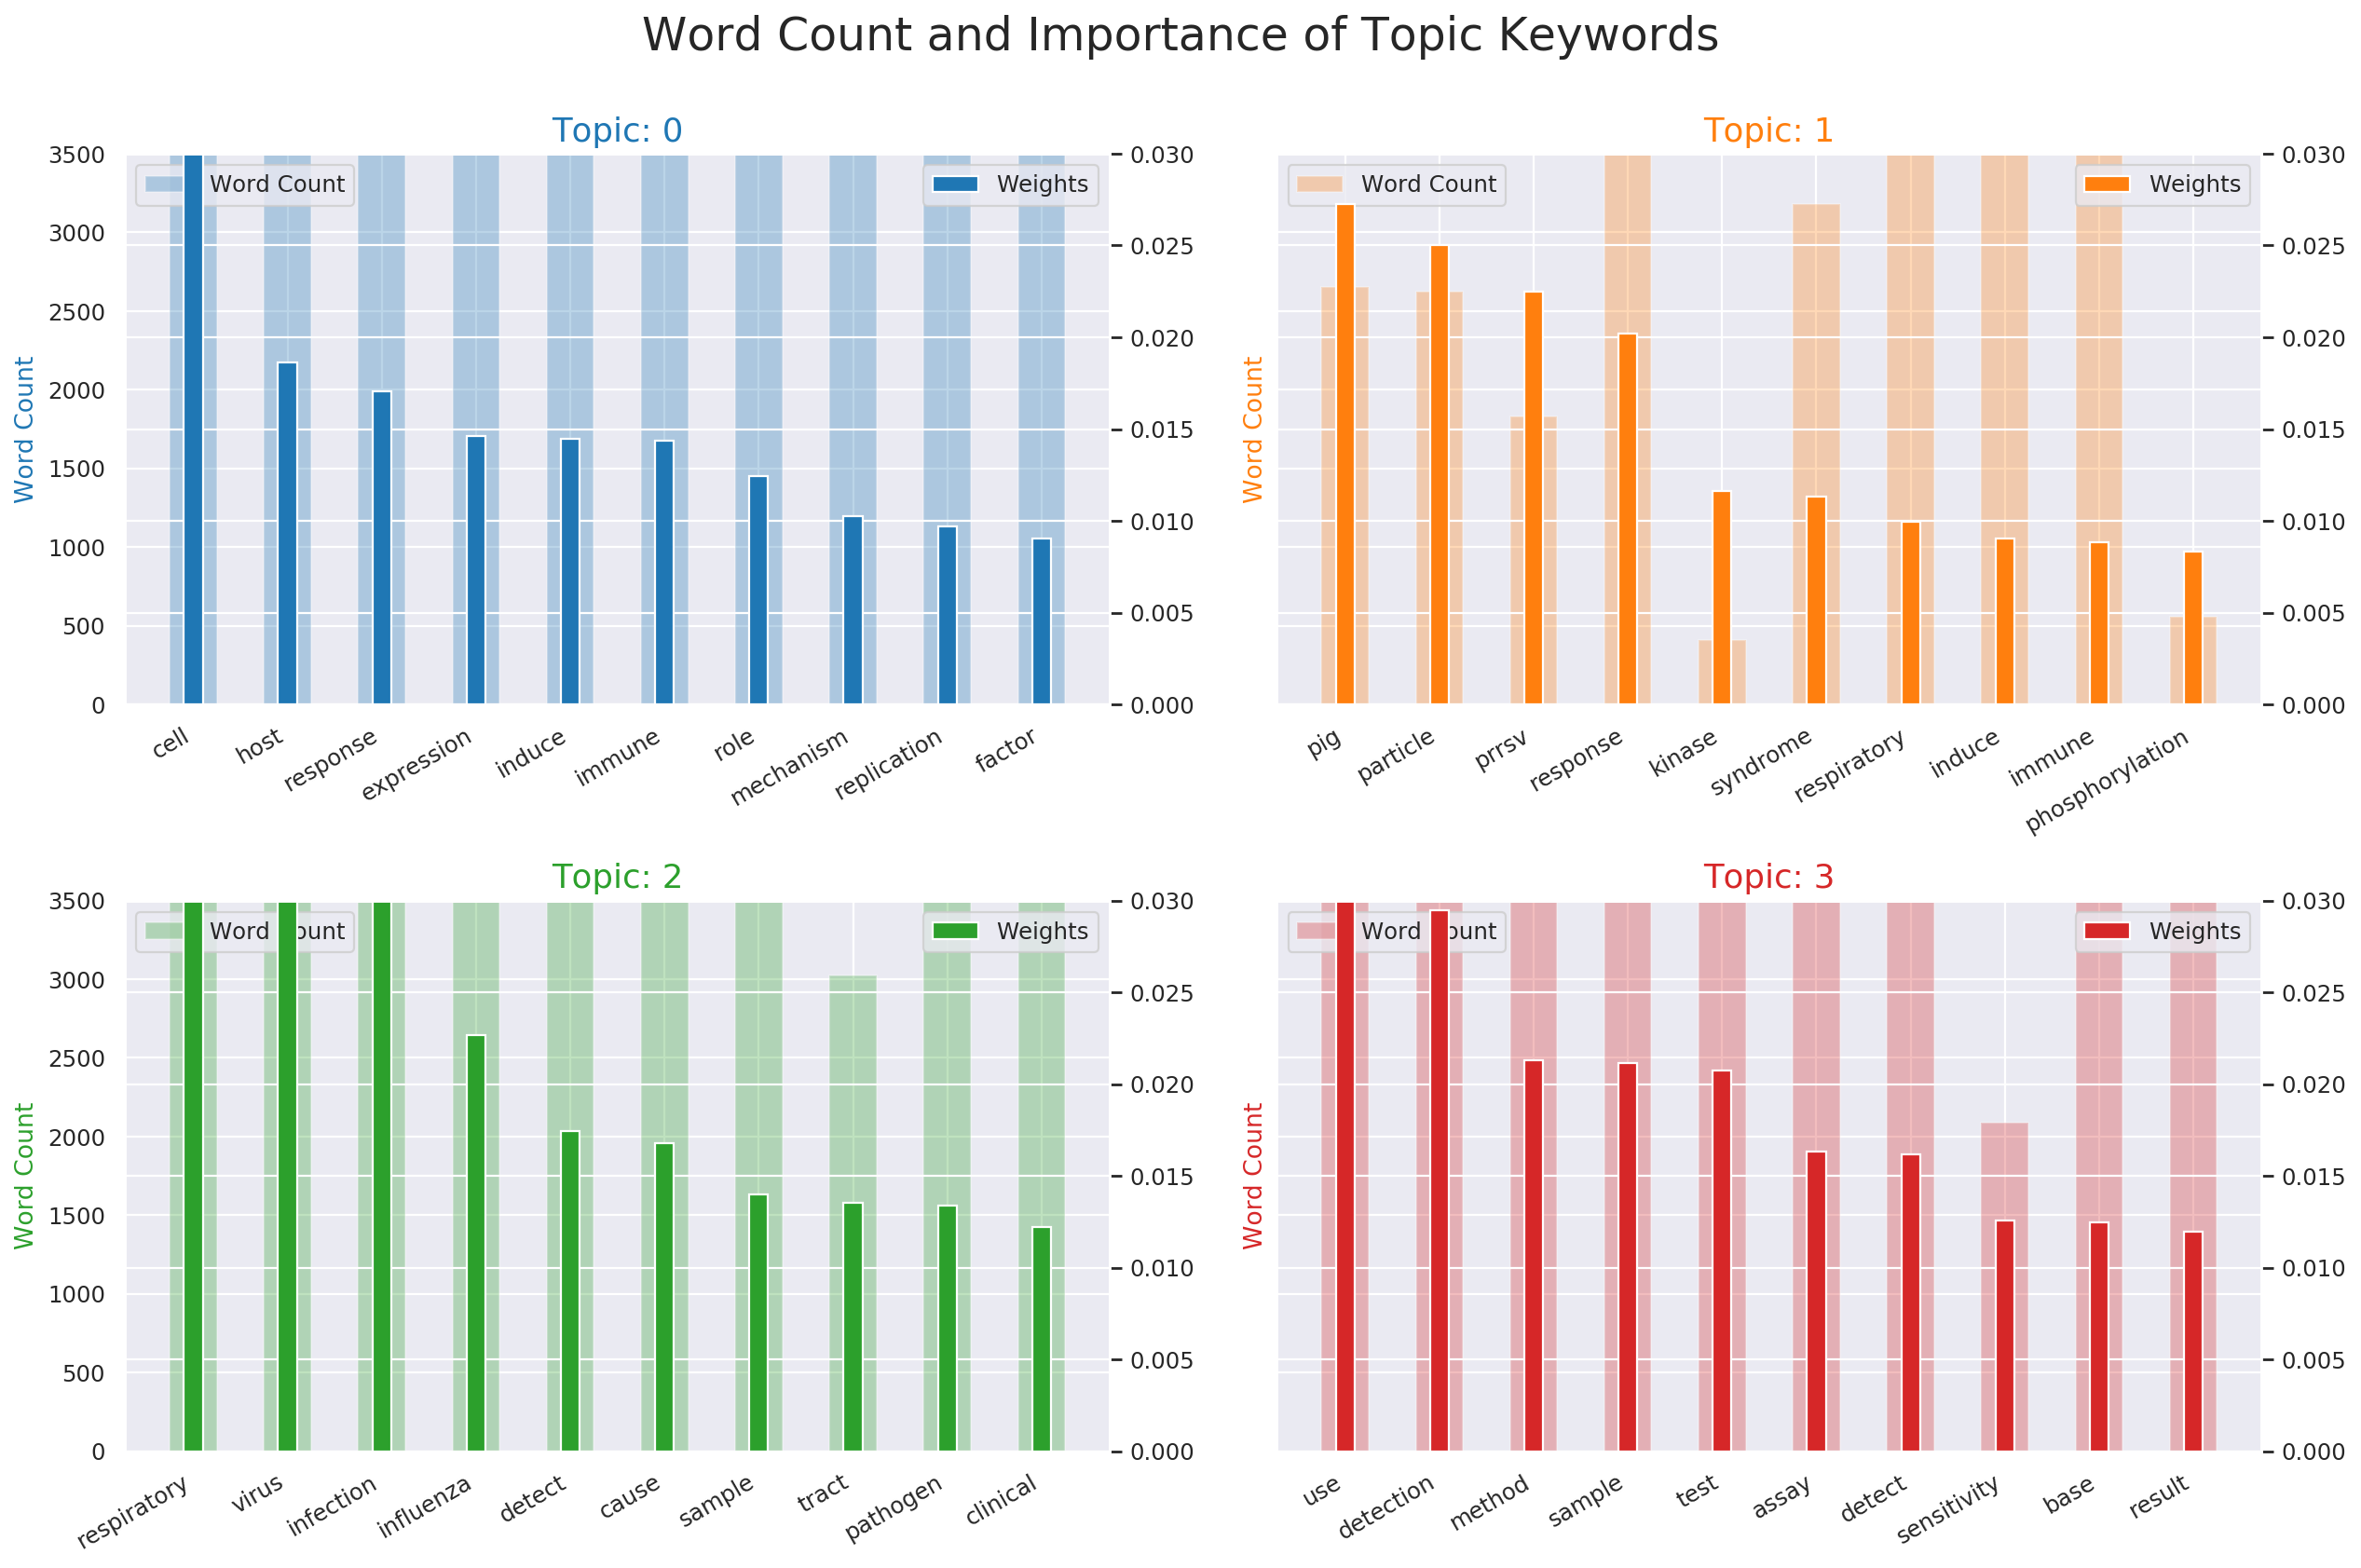

In [112]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Word Counts of Topic Keywords

In [114]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2722,"cell, host, response, expression, induce, immu...","[intrauterine, infection, abstract, etiologic,..."
1,1,10.0,0.3202,"vaccine, vaccination, response, vector, antibo...","[clinical, discordant, abstract, middle, age, ..."
2,2,2.0,0.5254,"respiratory, virus, infection, influenza, dete...","[epidemiology, respiratory, tract, infection, ..."
3,3,2.0,0.3644,"respiratory, virus, infection, influenza, dete...","[infectious, diarrhea, pathogenesis, risk, fac..."
4,4,0.0,0.5817,"cell, host, response, expression, induce, immu...","[perspective, pathogenesis, abstract, pathogen..."
5,5,2.0,0.4652,"respiratory, virus, infection, influenza, dete...","[acute, chronic, respiratory, tract, infection..."
6,6,2.0,0.5804,"respiratory, virus, infection, influenza, dete...","[acute, bronchitis, result, european, trial, a..."
7,7,12.0,0.5690,"bind, activity, protein, domain, target, cell,...","[determination, lauric, acid, hydroxylase, act..."
8,8,12.0,0.2751,"bind, activity, protein, domain, target, cell,...","[vesicle, contain, bovine, heart, mitochondria..."
9,9,12.0,0.3354,"bind, activity, protein, domain, target, cell,...","[oligomeric, renal, aminopeptidase, membrane, ..."


# Sentence Chart Colored by Topic


ValueError: too many values to unpack (expected 3)

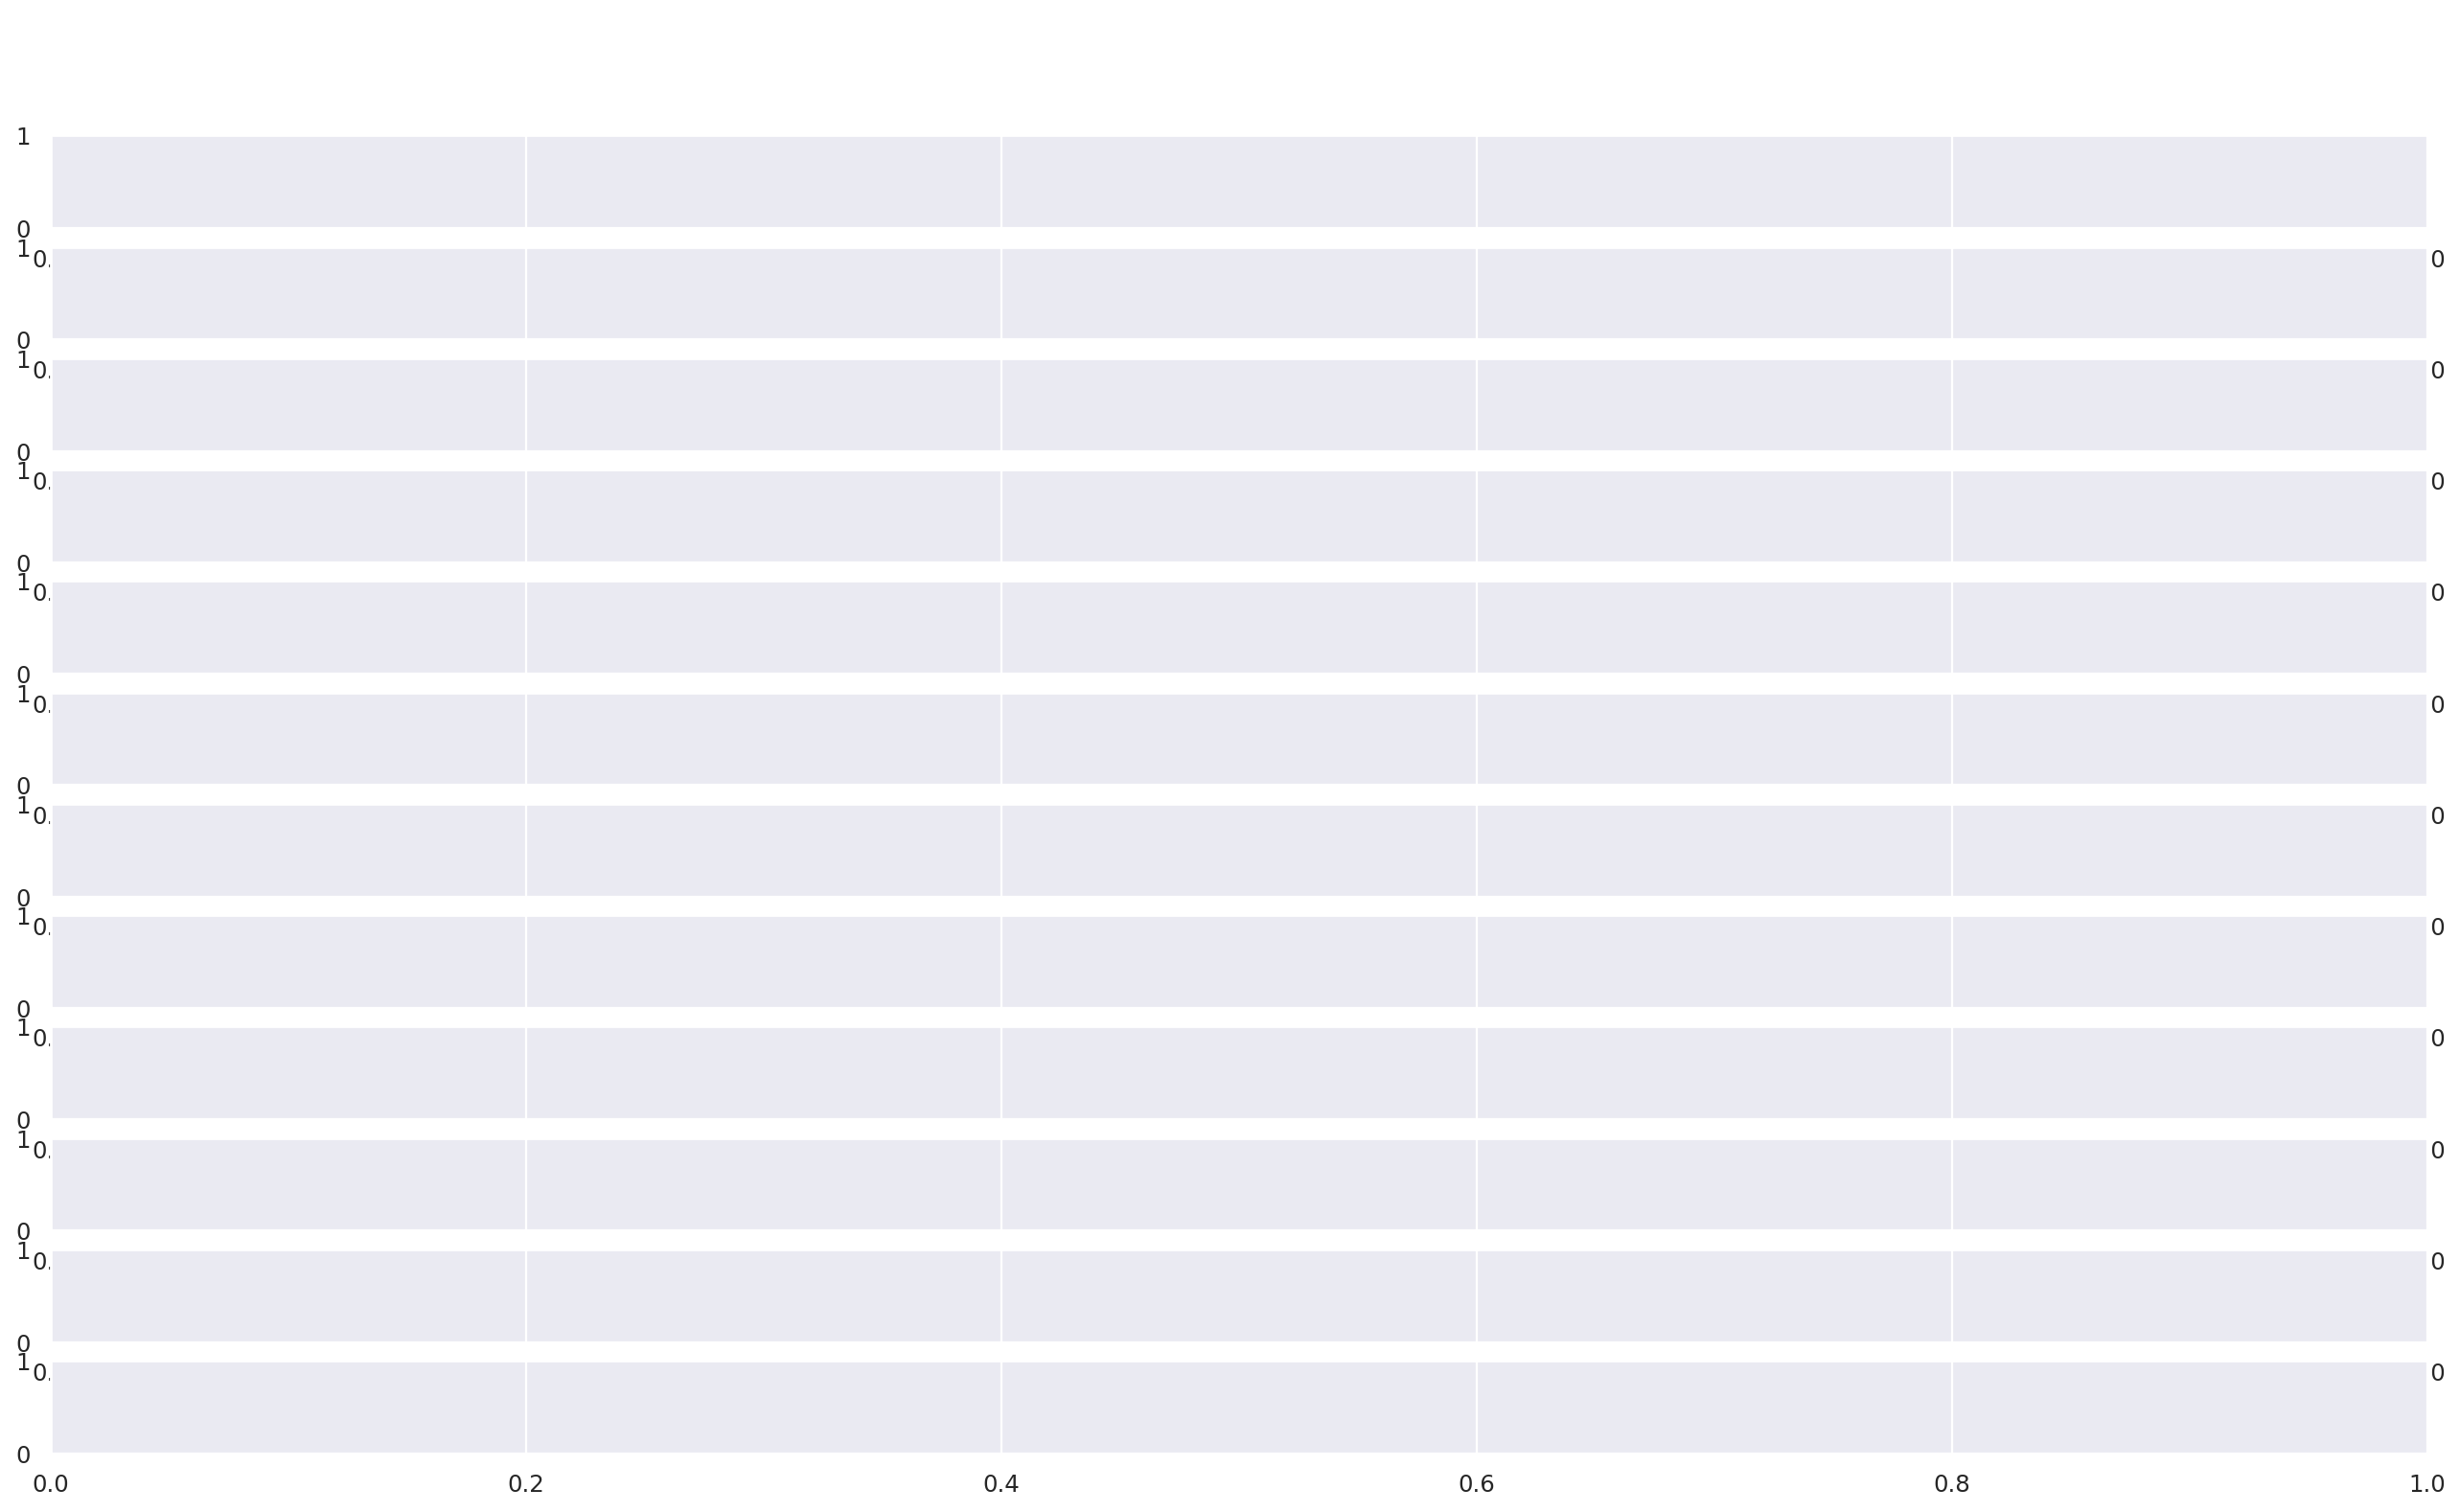

In [115]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 


# t-SNE Clustering Chart

In [116]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

TypeError: 'int' object is not iterable